In [1]:
# import library
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from pyproj import CRS, Transformer, Proj, transform
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
from gamma.utils import association, estimate_eps

## Setting file path data picking dan data stasiun

In [2]:
region = "rantau_dedap" # ini yang diubah
# region = 'bandung2000'

data_path = lambda x: os.path.join(f"asosiasi/region/{region}", x)
result_path = f"asosiasi/results/{region}"
if not os.path.exists(result_path):
    os.makedirs(result_path)
result_path = lambda x: os.path.join(f"asosiasi/results/{region}", x)
#station_csv = data_path("stations_10112019-13122020.csv")
station_csv = data_path("serd_stations.csv")
picks_csv = data_path("pn_picks202412.csv")
if not os.path.exists("asosiasi_figures"):
    os.makedirs("asosiasi_figures")
figure_dir = lambda x: os.path.join("asosiasi_figures", x)

nama_file_events = "gamma_events.csv"
nama_file_picks = "gamma_picks.csv"

## Input data picking dan data stasiun

In [3]:
## read picks
picks = pd.read_csv(picks_csv, parse_dates=["timestamp"])
picks = picks[picks['prob']>=0.1]
print("Pick format:", picks.iloc[:10])

## read stations
stations = pd.read_csv(station_csv)
print("Station format:", stations.iloc[:10])

Pick format:      id               timestamp      prob type                        filename
0  RD01 2024-12-01 00:01:55.540  0.129224    P  RD01_(B144)_RD_20241201_000000
1  RD01 2024-12-01 00:01:55.600  0.140935    S  RD01_(B144)_RD_20241201_000000
2  RD01 2024-12-01 00:08:04.780  0.154790    S  RD01_(B144)_RD_20241201_000000
3  RD01 2024-12-01 00:10:59.030  0.126697    P  RD01_(B144)_RD_20241201_000000
4  RD01 2024-12-01 00:11:07.040  0.357689    S  RD01_(B144)_RD_20241201_000000
5  RD01 2024-12-01 00:11:07.070  0.133574    P  RD01_(B144)_RD_20241201_000000
6  RD01 2024-12-01 00:11:30.370  0.332226    S  RD01_(B144)_RD_20241201_000000
7  RD01 2024-12-01 00:22:12.540  0.229122    S  RD01_(B144)_RD_20241201_000000
8  RD01 2024-12-01 00:23:21.660  0.246638    P  RD01_(B144)_RD_20241201_000000
9  RD01 2024-12-01 00:23:58.560  0.196812    S  RD01_(B144)_RD_20241201_000000
Station format:      id   longitude  latitude  elevation_m         utmx         utmy
0  RD01  103.408419 -4.192293    

In [4]:
picks

,id,timestamp,prob,type,filename
0,RD01,2024-12-01 00:01:55.540,0.129224,P,RD01_(B144)_RD_20241201_000000
1,RD01,2024-12-01 00:01:55.600,0.140935,S,RD01_(B144)_RD_20241201_000000
2,RD01,2024-12-01 00:08:04.780,0.154790,S,RD01_(B144)_RD_20241201_000000
3,RD01,2024-12-01 00:10:59.030,0.126697,P,RD01_(B144)_RD_20241201_000000
4,RD01,2024-12-01 00:11:07.040,0.357689,S,RD01_(B144)_RD_20241201_000000
...,...,...,...,...,...
362213,RD15,2024-12-31 23:46:42.150,0.135181,P,RD15_(AD18)_RD_20241231_230000
362214,RD15,2024-12-31 23:52:07.990,0.143809,P,RD15_(AD18)_RD_20241231_230000
362215,RD15,2024-12-31 23:52:10.440,0.122851,P,RD15_(AD18)_RD_20241231_230000
362216,RD15,2024-12-31 23:52:10.440,0.152754,S,RD15_(AD18)_RD_20241231_230000


## Setting parameter GaMMa

In [5]:
#.3# Automatic region; you can also specify a region
x0 = stations["longitude"].median()
y0 = stations["latitude"].median()
xmin = stations["longitude"].min()
xmax = stations["longitude"].max()
ymin = stations["latitude"].min()
ymax = stations["latitude"].max()
config = {}
config["center"] = (x0, y0)
config["xlim_degree"] = (2 * xmin - x0, 2 * xmax - x0) # 2
config["ylim_degree"] = (2 * ymin - y0, 2 * ymax - y0) # 2

In [6]:
# Definisikan proyeksi WGS84 dan UTM zona 48 Selatan
utm_proj = Proj(proj="utm", zone=48, south=True, ellps="WGS84")
transformer = Transformer.from_proj("epsg:4326", utm_proj)

# Fungsi untuk konversi koordinat
def convert_to_utm(lon, lat):
    utmx, utmy = transformer.transform(lat, lon)  # Lat/Lon sebagai input
    return utmx/1000, utmy/1000

# Terapkan fungsi ke dataframe
stations["x(km)"], stations["y(km)"] = zip(*stations.apply(lambda row: convert_to_utm(row["longitude"], row["latitude"]), axis=1))
stations["z(km)"] = stations["elevation_m"].apply(lambda x: -x/1e3)

In [7]:
# ## projection to km
# proj = Proj(f"+proj=sterea +lon_0={config['center'][0]} +lat_0={config['center'][1]} +units=km")
# stations[["x(km)", "y(km)"]] = stations.apply(lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1)

# # stations["x(km)"] = stations['utmx']/1e3
# # stations["y(km)"] = stations['utmy']/1e3
# stations["z(km)"] = stations["elevation_m"].apply(lambda x: -x/1e3)


In [8]:
# set number of cpus
config["ncpu"] = 32

# Gamma
config["dims"] = ['x(km)', 'y(km)', 'z(km)']
config["use_dbscan"] = True
config["use_amplitude"] = False
# config["x(km)"] = proj(longitude=config["xlim_degree"], latitude=[config["center"][1]] * 2)[0]
# config["y(km)"] = proj(longitude=[config["center"][0]] * 2, latitude=config["ylim_degree"])[1]
config["x(km)"] = (316, 325)
config["y(km)"] = (9528, 9550)
config["z(km)"] = (0, 5)
config["vel"] = {"p": 5.0, "s": 5.0 / 1.67}
config["method"] = "BGMM"
if config["method"] == "BGMM":
    config["oversample_factor"] = 10
if config["method"] == "GMM":
    config["oversample_factor"] = 1

# DBSCAN
config["bfgs_bounds"] = (
    (config["x(km)"][0] - 2, config["x(km)"][1] + 2),  # x
    (config["y(km)"][0] - 2, config["y(km)"][1] + 2),  # y
    (0, config["z(km)"][1] + 2),  # z
    (None, None),  # t
)
config["dbscan_eps"] = 0.5 #estimate_eps(stations, config["vel"]["p"]) #25  # seconds
config["dbscan_min_samples"] = 4


#using Eikonal for 1D velocity model
if region == "ridgecrest":
    zz = [0.0, 5.5, 16.0, 32.0]
    vp = [5.5, 5.5,  6.7,  7.8]
    vp_vs_ratio = 1.73
    vs = [v / vp_vs_ratio for v in vp]
    h = 1.0
    vel = {"z": zz, "p": vp, "s": vs}
    config["eikonal"] = {"vel": vel, "h": h, "xlim": config["x(km)"], "ylim": config["y(km)"], "zlim": config["z(km)"]}
    
elif region == "muara_laboh2022":
    # zz = [-2, -0.3, 1.2, 6.1, 14.1]
    # vp = [3.45, 4, 4.3, 6.2, 8]
    # vs = [1.92, 2.22, 2.39, 3.44, 4.44]
    
    vp_vs_ratio = 1.8
    zz = [0.00,  1.00,  1.50,  2.00,  2.50,  3.00,  3.50,  4.00,  4.50,  5.00,  7.00,  12.00]
    vp = [3.64,  3.67,  3.86,  3.87,  3.91,  4.25,  4.35,  4.40,  4.41,  4.47,  4.50,  6.12]
    vs = [v / vp_vs_ratio for v in vp]
    h = 0.01
    vel = {"z": zz, "p": vp, "s": vs}
    config["eikonal"] = {"vel": vel, "h": h, "xlim": config["x(km)"], "ylim": config["y(km)"], "zlim": config["z(km)"]}

elif region == "rantau_dedap":
    vp_vs_ratio = 1.67
    #zz = [-2.638, -1.90, -0.59, 0.22, 2.50, 7.00, 9.00, 15.00, 33.00]
    #vp = [2.68, 2.99, 3.95, 4.50, 4.99, 5.60, 5.80, 6.40, 8.00]
    #vs = [1.6, 1.79, 2.37, 2.69, 2.99, 3.35, 3.47, 3.83, 4.79]

    zz = [0.00, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 4.50, 5.00, 7.00, 12.00]
    vp = [4.35, 4.67, 4.77, 4.88, 4.99, 5.06, 5.12, 5.19, 5.26, 5.32, 5.60, 6.10]
    vs = [2.60, 2.79, 2.85, 2.92, 2.99, 3.03, 3.07, 3.11, 3.15, 3.19, 3.35, 3.65]
    
    h = 0.01
    vel = {"z": zz, "p": vp, "s": vs}
    config["eikonal"] = {"vel": vel, "h": h, "xlim": config["x(km)"], "ylim": config["y(km)"], "zlim": config["z(km)"]}
    
elif region == "project_chile":
    velocity_model = pd.read_csv(data_path("iasp91.csv"), names=["zz", "rho", "vp", "vs"])
    velocity_model = velocity_model[velocity_model["zz"] <= config["z(km)"][1]]
    vel = {"z": velocity_model["zz"].values, "p": velocity_model["vp"].values, "s": velocity_model["vs"].values}
    h = 1.0
    config["eikonal"] = {"vel": vel, "h": h, "xlim": config["x(km)"], "ylim": config["y(km)"], "zlim": config["z(km)"]}
else:
    print("Using uniform velocity model")

if region == "project_chile":
    config["initial_points"] = [1, 1, 1] # x, y, z

# Filtering
config["min_picks_per_eq"] = 6
config["min_p_picks_per_eq"] = 1
config["min_s_picks_per_eq"] = 1
config["max_sigma11"] = 1
config["max_sigma22"] = 1.0
config["max_sigma12"] = 1.0

## filter picks without amplitude measurements
if config["use_amplitude"]:
    picks = picks[picks["amp"] != -1]

for k, v in config.items():
    print(f"{k}: {v}")

center: (103.372777, -4.22405)
xlim_degree: (103.340781, 103.46234500000001)
ylim_degree: (-4.26651, -4.1605360000000005)
ncpu: 32
dims: ['x(km)', 'y(km)', 'z(km)']
use_dbscan: True
use_amplitude: False
x(km): (316, 325)
y(km): (9528, 9550)
z(km): (0, 5)
vel: {'p': 5.0, 's': 2.9940119760479043}
method: BGMM
oversample_factor: 10
bfgs_bounds: ((314, 327), (9526, 9552), (0, 7), (None, None))
dbscan_eps: 0.5
dbscan_min_samples: 4
eikonal: {'vel': {'z': [0.0, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 7.0, 12.0], 'p': [4.35, 4.67, 4.77, 4.88, 4.99, 5.06, 5.12, 5.19, 5.26, 5.32, 5.6, 6.1], 's': [2.6, 2.79, 2.85, 2.92, 2.99, 3.03, 3.07, 3.11, 3.15, 3.19, 3.35, 3.65]}, 'h': 0.01, 'xlim': (316, 325), 'ylim': (9528, 9550), 'zlim': (0, 5)}
min_picks_per_eq: 6
min_p_picks_per_eq: 1
min_s_picks_per_eq: 1
max_sigma11: 1
max_sigma22: 1.0
max_sigma12: 1.0


# Asosiasi

In [9]:
event_idx0 = 1 ## current earthquake index
assignments = []
gamma_catalog, assignments = association(picks, stations, config, event_idx0, config["method"])
event_idx0 += len(gamma_catalog)

Loading precomputed timetable...
Associating 811 clusters with 8 CPUs


In [10]:
gamma_catalog

[{'time': '2024-12-05T05:04:47.340',
  'magnitude': 999,
  'sigma_time': 0.2752818478042495,
  'sigma_amp': 0,
  'cov_time_amp': 0,
  'gamma_score': 14.0,
  'num_picks': 14,
  'num_p_picks': 13,
  'num_s_picks': 1,
  'event_index': 3,
  'x(km)': 319.4089280244886,
  'y(km)': 9529.801585018266,
  'z(km)': 0.0},
 {'time': '2024-12-27T00:31:01.782',
  'magnitude': 999,
  'sigma_time': 0.2056419271800407,
  'sigma_amp': 0,
  'cov_time_amp': 0,
  'gamma_score': 12.0,
  'num_picks': 11,
  'num_p_picks': 5,
  'num_s_picks': 6,
  'event_index': 4,
  'x(km)': 318.70295736780014,
  'y(km)': 9534.091344507622,
  'z(km)': 0.0},
 {'time': '2024-12-10T07:37:46.737',
  'magnitude': 999,
  'sigma_time': 0.23651501486494575,
  'sigma_amp': 0,
  'cov_time_amp': 0,
  'gamma_score': 10.0,
  'num_picks': 10,
  'num_p_picks': 1,
  'num_s_picks': 9,
  'event_index': 2,
  'x(km)': 318.67281524801564,
  'y(km)': 9530.028974855513,
  'z(km)': 0.0},
 {'time': '2024-12-31T20:22:26.519',
  'magnitude': 999,
  'sig

## Simpan hasil asosiasi

In [11]:
# Fungsi untuk konversi koordinat
def convert_to_latlon(utmx_km, utmy_km):
    utm_proj = Proj(proj="utm", zone=48, south=True, ellps="WGS84")
    transformer = Transformer.from_proj(utm_proj, "epsg:4326")
    
    utmx_m = utmx_km * 1000  # Konversi ke meter
    utmy_m = utmy_km * 1000  # Konversi ke meter
    lon, lat = transformer.transform(utmx_m, utmy_m)  # Transformasi UTM -> Lon/Lat
    return lon, lat

In [12]:
stations

,id,longitude,latitude,elevation_m,utmx,utmy,x(km),y(km),z(km)
0,RD01,103.408419,-4.192293,1504,323344.9658,9536437.964,323.344966,9536.437964,-1.504
1,RD02,103.401842,-4.210773,1753,322618.9510,9534392.981,322.618951,9534.392981,-1.753
2,RD03,103.390728,-4.205930,1899,321383.9716,9534925.980,321.383972,9534.925980,-1.899
3,RD04,103.417561,-4.210271,1719,324363.9490,9534452.048,324.363949,9534.452048,-1.719
4,RD05,103.378906,-4.203970,2013,320071.0291,9535140.003,320.071029,9535.140003,-2.013
5,RD06,103.379951,-4.212581,1943,320189.0231,9534188.039,320.189023,9534.188039,-1.943
6,RD07,103.381069,-4.220451,2185,320314.9525,9533318.032,320.314952,9533.318032,-2.185
7,RD08,103.372253,-4.224050,2167,319337.0364,9532918.012,319.337036,9532.918012,-2.167
8,RD09,103.364433,-4.224820,2258,318469.0427,9532831.043,318.469043,9532.831043,-2.258
9,RD10,103.359078,-4.231261,2412,317876.0360,9532117.536,317.876036,9532.117536,-2.412


In [13]:
## create catalog
gamma_catalog = pd.DataFrame(gamma_catalog)
#gamma_catalog[["longitude","latitude"]] = gamma_catalog.apply(lambda x: pd.Series(proj(longitude=x["x(km)"], latitude=x["y(km)"], inverse=True)), axis=1)
# Terapkan fungsi ke dataframe
gamma_catalog["latitude"], gamma_catalog["longitude"] = zip(*gamma_catalog.apply(lambda row: convert_to_latlon(row["x(km)"], row["y(km)"]), axis=1))

gamma_catalog["depth_km"] = gamma_catalog["z(km)"]
gamma_catalog['magnitude'] = gamma_catalog['magnitude'].replace(999, 0)

# Filter data dengan z(km) > 0.5
gamma_catalog = gamma_catalog[gamma_catalog["z(km)"] != 110] ############################

gamma_catalog.to_csv(result_path(nama_file_events), index=False, 
                float_format="%.3f",
                date_format='%Y-%m-%dT%H:%M:%S.%f')


assignments = pd.DataFrame(assignments, columns=["pick_index", "event_index", "gamma_score"])
## add assignment to picks
filtered_event_indices = gamma_catalog["event_index"].tolist()

picks = picks.join(assignments.set_index("pick_index")).fillna(-1).astype({'event_index': int})
filtered_picks = picks[picks["event_index"].isin(filtered_event_indices)]
filtered_picks.to_csv(result_path(nama_file_picks), index=False, 
                date_format='%Y-%m-%dT%H:%M:%S.%f')

In [14]:
# ## create catalog
# gamma_catalog = pd.DataFrame(gamma_catalog)
# #gamma_catalog[["longitude","latitude"]] = gamma_catalog.apply(lambda x: pd.Series(proj(longitude=x["x(km)"], latitude=x["y(km)"], inverse=True)), axis=1)
# # Terapkan fungsi ke dataframe
# gamma_catalog["latitude"], gamma_catalog["longitude"] = zip(*gamma_catalog.apply(lambda row: convert_to_latlon(row["x(km)"], row["y(km)"]), axis=1))

# gamma_catalog["depth_km"] = gamma_catalog["z(km)"]
# gamma_catalog.to_csv(result_path(nama_file_events), index=False, 
#                 float_format="%.3f",
#                 date_format='%Y-%m-%dT%H:%M:%S.%f')

# ## add assignment to picks
# assignments = pd.DataFrame(assignments, columns=["pick_index", "event_index", "gamma_score"])
# picks = picks.join(assignments.set_index("pick_index")).fillna(-1).astype({'event_index': int})
# picks.to_csv(result_path(nama_file_picks), index=False, 
#                 date_format='%Y-%m-%dT%H:%M:%S.%f')

## Perbaiki index

In [15]:
gamma_events = pd.read_csv(result_path(nama_file_events))
gamma_picks =pd.read_csv(result_path(nama_file_picks))

# Step 1: Sort gamma_events by 'time'
gamma_events_sorted = gamma_events.sort_values(by='time').reset_index(drop=True)

# Step 2: Assign new event_index starting from 1 after sorting by time
gamma_events_sorted['new_event_index'] = gamma_events_sorted.index + 1

# Step 3: Create a mapping from old event_index to new event_index
index_mapping = dict(zip(gamma_events_sorted['event_index'], gamma_events_sorted['new_event_index']))

# Step 4: Use the mapping to update event_index in gamma_picks
gamma_picks['event_index'] = gamma_picks['event_index'].map(index_mapping)
gamma_events_sorted.drop(columns='event_index',inplace=True)
gamma_events_sorted.rename(columns={'new_event_index': 'event_index'}, inplace=True)
gamma_picks.sort_values(by='event_index', inplace=True)

gamma_events_sorted.to_csv(result_path(nama_file_events),index=False)
gamma_picks.to_csv((result_path(nama_file_picks)),index=False)

# Visualisasi

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
result_label="GaMMA"
catalog_label="Standard"

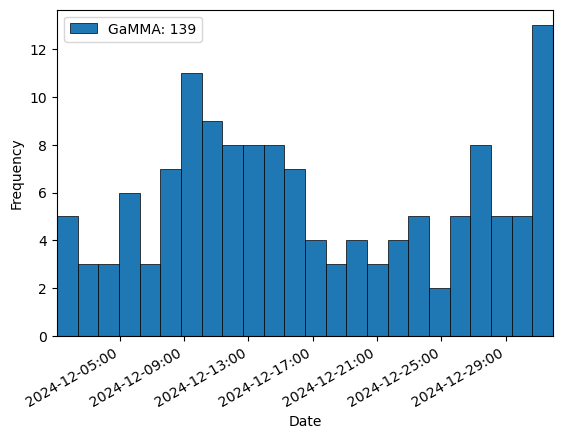

In [17]:
stations = pd.read_csv(data_path("serd_stations.csv"))
gamma_events = pd.read_csv(result_path(nama_file_events), parse_dates=["time"])

if os.path.exists(data_path("katalogall_supreme.csv")):
    standard_catalog = pd.read_csv(data_path("katalogall_supreme.csv"))
   # Mengonversi kolom 'time' ke format datetime
    standard_catalog['time'] = pd.to_datetime(standard_catalog['time'], format='%d/%m/%Y %H:%M', errors='coerce')
    standard_catalog = standard_catalog[standard_catalog['time'].dt.year == 2022]
    
    # start_date = '2020-04-25'
    # end_date = '2020-12-13'
    # standard_catalog = standard_catalog[(standard_catalog['time'] >= start_date) & (standard_catalog['time'] <= end_date)]

    
    starttime = standard_catalog["time"].min()
    endtime = standard_catalog["time"].max()
else:
    standard_catalog = None
    starttime = gamma_events["time"].min()
    endtime = gamma_events["time"].max()


plt.figure()
plt.hist(gamma_events["time"], range=(starttime, endtime), bins=24, edgecolor="k", alpha=1.0, linewidth=0.5, label=f"{result_label}: {len(gamma_events['time'])}")
if standard_catalog is not None:
    plt.hist(standard_catalog["time"], range=(starttime, endtime), bins=24, edgecolor="k", alpha=0.6, linewidth=0.5, label=f"{catalog_label}: {len(standard_catalog['time'])}")
plt.ylabel("Frequency")
plt.xlabel("Date")
plt.gca().autoscale(enable=True, axis='x', tight=True)
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d:%H'))
plt.gcf().autofmt_xdate()
plt.legend()
#plt.savefig(figure_dir("earthquake_number.png"), bbox_inches="tight", dpi=300)
#plt.savefig(figure_dir("earthquake_number.pdf"), bbox_inches="tight")
plt.show();

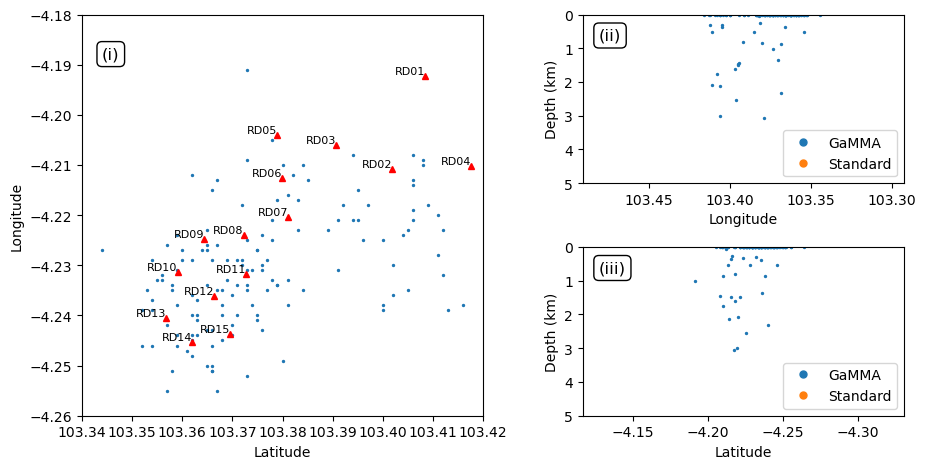

In [18]:
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([1.5,1]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.92]
grd = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.5, 1], height_ratios=[1,1])
fig.add_subplot(grd[:, 0])
plt.scatter(gamma_events["longitude"], gamma_events["latitude"], s=2)
if standard_catalog is not None:
    plt.plot(standard_catalog["longitude"], standard_catalog["latitude"], '.', markersize=2, alpha=0.6, c='red')
plt.axis("scaled")
plt.xlim(np.array(config["xlim_degree"]))
plt.xlim(103.34,103.42)
#plt.ylim(np.array(config["ylim_degree"]))
plt.ylim(-4.26,-4.18)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.gca().set_prop_cycle(None)
plt.plot([], [], '.', markersize=10, label=f"{result_label}", rasterized=True)
plt.plot([], [], '.', markersize=10, label=f"{catalog_label}", rasterized=True)
plt.plot(stations["longitude"], stations["latitude"], 'r^', markersize=5, alpha=1, label="Stations")
# Menambahkan label untuk setiap stasiun
for i, row in stations.iterrows():
    plt.text(row["longitude"], row["latitude"], row["id"], fontsize=8, ha='right', va='bottom')
    
#plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[0, 1])
plt.scatter(gamma_events["longitude"], gamma_events["depth_km"], s=2, alpha=1.0, rasterized=True)
if standard_catalog is not None:
    plt.plot(standard_catalog["longitude"], standard_catalog["depth_km"], '.', markersize=2, alpha=0.3,c='red')
plt.xlim(np.array(config["xlim_degree"])+np.array([0.15,-0.17]))
plt.ylim(config["z(km)"])
plt.gca().invert_yaxis()
plt.xlabel("Longitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot([], [], '.', markersize=10, label=f"{result_label}")
plt.plot([], [], '.', markersize=10, label=f"{catalog_label}")
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[1, 1])
plt.scatter(gamma_events["latitude"], gamma_events["depth_km"], s=2, alpha=1.0, rasterized=True)
if standard_catalog is not None:
    plt.plot(standard_catalog["latitude"], standard_catalog["depth_km"], '.', markersize=2, alpha=0.3,c='red')
plt.xlim(np.array(config["ylim_degree"])+np.array([0.15,-0.17]))
#plt.xlim(np.array(config["ylim_degree"]))
plt.ylim(config["z(km)"])
plt.gca().invert_yaxis()
plt.xlabel("Latitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot([], [], '.', markersize=10, label=f"{result_label}")
plt.plot([], [], '.', markersize=10, label=f"{catalog_label}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
#plt.savefig(figure_dir("earthquake_location.png"), bbox_inches="tight", dpi=300)
#plt.savefig(figure_dir("earthquake_location.pdf"), bbox_inches="tight", dpi=300)
plt.show();